In [1]:
#lib import
import numpy as np
import pandas as pd
import pydicom # read *.dcm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import matplotlib.pyplot as plt
import nibabel as nib

# ROOT = '../input/rsna-2022-cervical-spine-fracture-detection'
ROOT = 'RSNA_data'

In [2]:
# File Read
filenames = os.listdir(ROOT)

# define dir
train_dir = os.path.join(ROOT, 'train.csv')
test_dir = os.path.join(ROOT, 'test.csv')
bbox_dir = os.path.join(ROOT, 'train_bounding_boxes.csv')
sap_subm_dir = os.path.join(ROOT, 'sample_submission.csv')
train_images_dir = os.path.join(ROOT, 'train_images')
test_images_dir = os.path.join(ROOT, 'test_images')
seg_dir = os.path.join(ROOT, 'segmentations')

# read csv
train = pd.read_csv(train_dir)
test = pd.read_csv(test_dir)
bbox_df = pd.read_csv(bbox_dir)
sap_subm = pd.read_csv(sap_subm_dir)

# get train & test filenames
train_images = os.listdir(train_images_dir)
test_images = os.listdir(test_images_dir)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10633.1.1
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10633.1.1
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183138.826224'
(0010, 0010) Patient's Name                      PN: '10633'
(0010, 0020) Patient ID                          LO: '10633'
(0018, 0050) Slice Thickness                     DS: '1.0'
(00

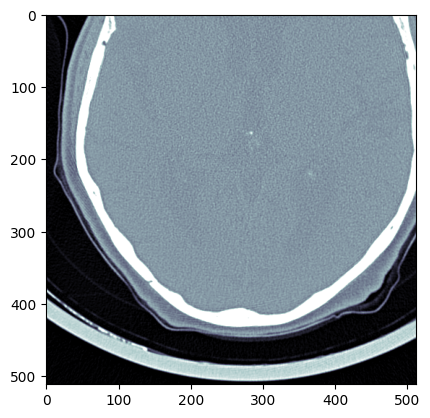

In [3]:
# check img
index = 6
foldername = train_images[index]
foldername = '1.2.826.0.1.3680043.10633'
filename = os.listdir(os.path.join(train_images_dir, foldername))[0]
ds = pydicom.dcmread(os.path.join(train_images_dir, foldername,filename))
print(ds)
img = apply_voi_lut(ds.pixel_array,ds)
plt.imshow(img, cmap="bone")
plt.show()


1.2.826.0.1.3680043.11827


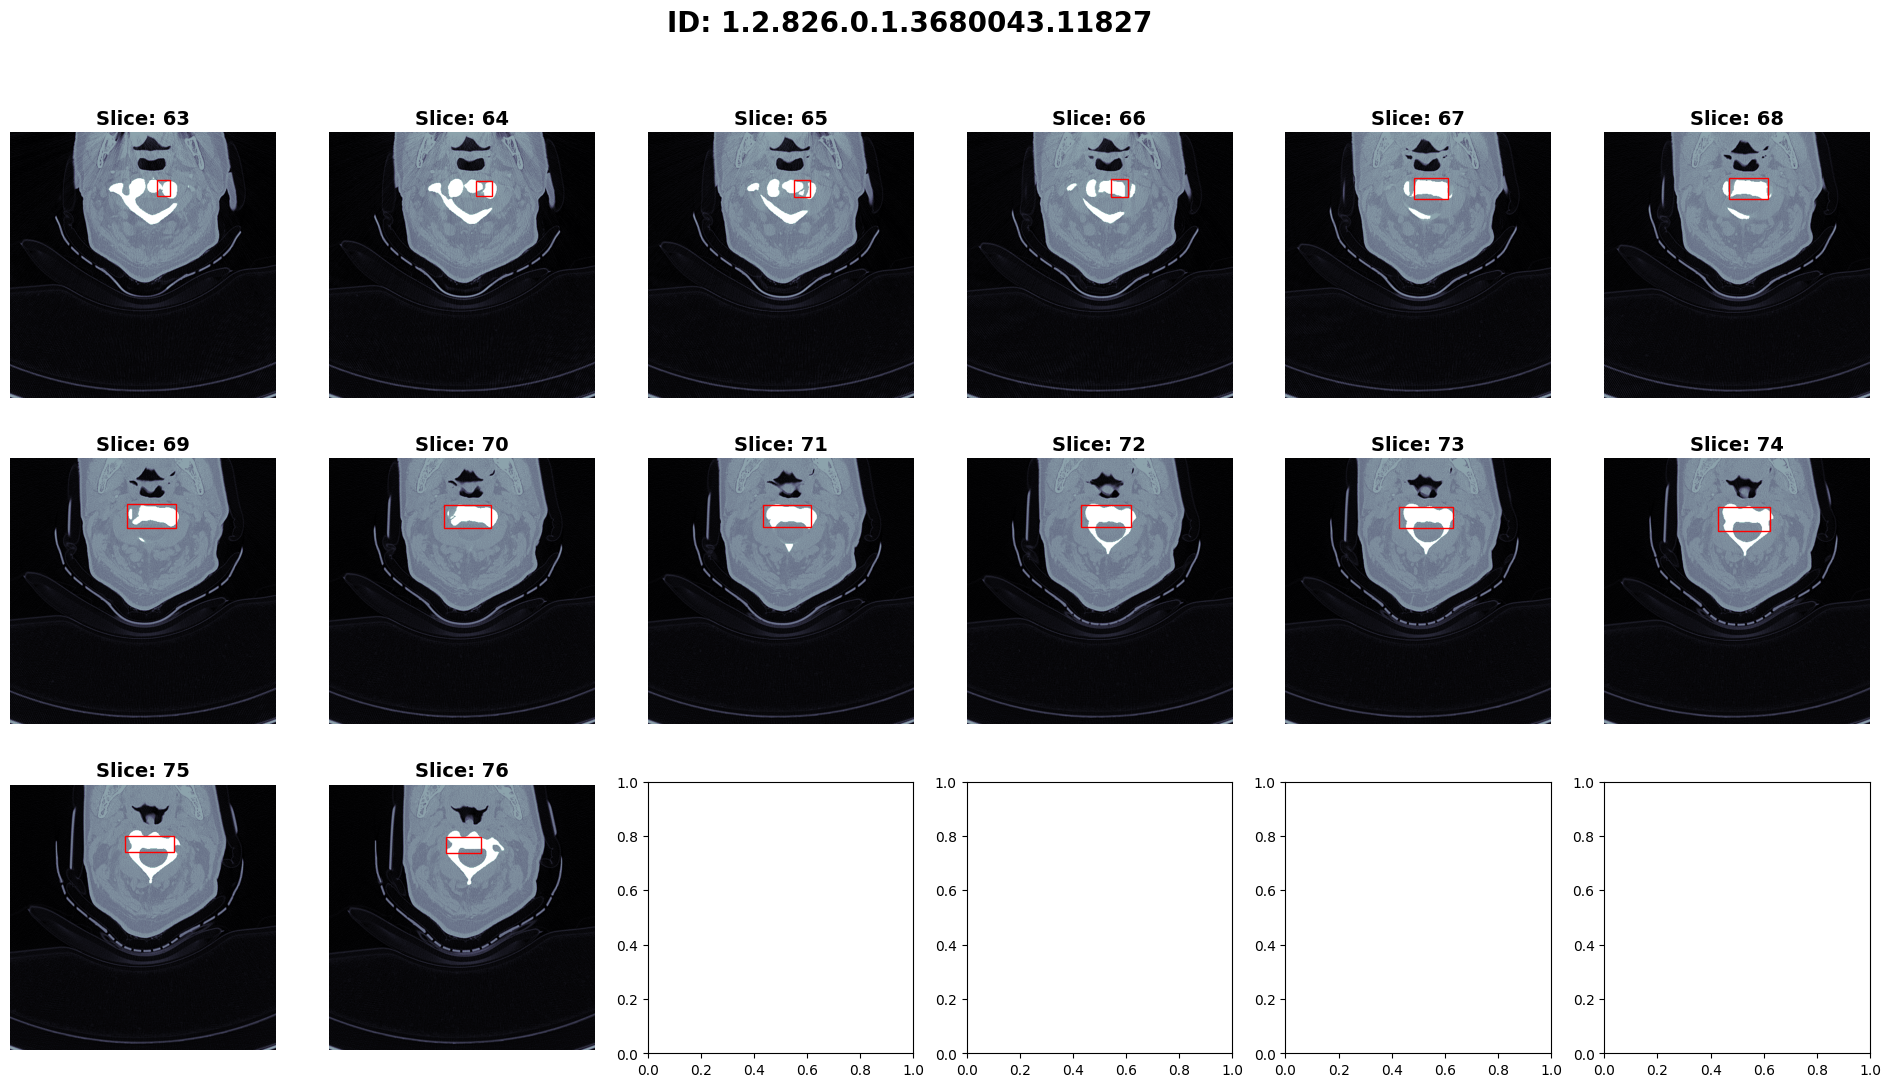

In [4]:
# draw seg and bbox
index = 2
# foldername = train_images[index]

# find have seg file
seg_file = os.listdir(seg_dir)
foldername_list = seg_file[index].split('.')[:len(seg_file[index].split('.'))-1]
foldername = ''
for index, i in enumerate(foldername_list):
    foldername += i
    if index != len(foldername_list) - 1:
        foldername += '.'
print(foldername)

fractured_info = train[train['StudyInstanceUID']==foldername]
bbox_info = bbox_df[bbox_df['StudyInstanceUID']==foldername]

img_with_bbox_index = np.asarray(bbox_info['slice_number'])
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {foldername}', weight="bold", size=20)

# read segmentations
nii_example = nib.load(os.path.join(seg_dir, foldername+'.nii'))
seg = nii_example.get_fdata()
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)

for i, index in enumerate(img_with_bbox_index):
    file = os.path.join(train_images_dir, foldername,f"{index}.dcm")
    ds = pydicom.dcmread(file)
    img = apply_voi_lut(ds.pixel_array,ds)

    # draw bbox
    bbox = np.asarray([bbox_info[bbox_info['slice_number']==index]]).T
    # print(bbox)
    rect = plt.Rectangle((bbox[1], bbox[2]), bbox[3], bbox[4], fill=False, edgecolor = 'red',linewidth=1)

    # draw segamentation
    seg_index = seg[index - 1]
    img [np.where(seg_index != 0)] = 5000

    # Plot the image
    x = i // 6
    y = i % 6

    slice_no = index
    axes[x, y].add_patch(rect)
    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')


因为每个instance都有$N$张图片，因此需要去找到，每张图片是属于那一块骨头(C1-C7)

In [5]:
# Find dcm data

In [6]:
skip_train_file = ['1.2.826.0.1.3680043.20574', '1.2.826.0.1.3680043.29952']